In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder, 
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import CLEAN_DATA
from src.models import train_and_validate_regression_model, organize_results, grid_search_cv_regressor
from src.plots import plot_coefs, plot_residuals, plot_compare_models_metrics, plot_residuals_estimator
from src.utils import dataframe_coefs

In [2]:
df = pd.read_parquet(CLEAN_DATA)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,population_per_household,rooms_per_household,bedrooms_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,6+,2.555556,6.984127,1.023810,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,6+,2.109842,6.238137,0.971880,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,1.5,2.026891,4.294117,1.117647,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,1.5,2.640152,4.242424,1.071970,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,1.5,2.362768,5.343676,1.085919,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17540 entries, 0 to 17539
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17540 non-null  float32 
 1   latitude                  17540 non-null  float32 
 2   housing_median_age        17540 non-null  int8    
 3   total_rooms               17540 non-null  int16   
 4   total_bedrooms            17540 non-null  int16   
 5   population                17540 non-null  int16   
 6   households                17540 non-null  int16   
 7   median_income             17540 non-null  float32 
 8   median_house_value        17540 non-null  int32   
 9   ocean_proximity           17540 non-null  category
 10  median_income_cat         17540 non-null  category
 11  population_per_household  17540 non-null  float32 
 12  rooms_per_household       17540 non-null  float32 
 13  bedrooms_per_household    17540 non-null  floa

### separando colunas para diferentes processamentos

In [4]:
# coluna do target
column_target = ['median_house_value']

# colunas categóricas ordinárias - ordinal encoder
columns_cat_ordinal = ['median_income_cat']

#colunas categóricas nominais - one hot encoder
columns_cat_nominal = ['ocean_proximity']

# colunas numéricas para robust scaler
columns_robust_scaler = df.columns.difference(column_target + columns_cat_ordinal + columns_cat_nominal)

# colunas numéricas para standard scaler - colunas que possuem comportamento diferente
columns_standard_scaler = ['latitude', 'longitude', 'housing_median_age']

# colunas numéricas para standard scaler - colunas que possuem comportamento assimétrico
columns_power_transformer = df.columns.difference(column_target + columns_cat_ordinal + columns_cat_nominal + columns_standard_scaler)

In [5]:
prep_cat = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), columns_cat_ordinal),
        ('one_hot_encoder', OneHotEncoder(drop='first'), columns_cat_nominal),
    ],
    remainder='passthrough'
)

prep_simple = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), columns_cat_ordinal),
        ('one_hot_encoder', OneHotEncoder(drop='first'), columns_cat_nominal),
        ('robust_scaler', RobustScaler(), columns_robust_scaler), # usando robust para menor sensibilidade a outliers
    ],
)

prep_complete = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), columns_cat_ordinal),
        ('one_hot_encoder', OneHotEncoder(drop='first'), columns_cat_nominal),
        ('standard_scaler', StandardScaler(), columns_standard_scaler),
        ('power_transformer', PowerTransformer(), columns_power_transformer),
    ],
)

In [6]:
X = df.drop(columns=column_target)
y = df[column_target]

X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,population_per_household,rooms_per_household,bedrooms_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,6+,2.555556,6.984127,1.023810,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,6+,2.109842,6.238137,0.971880,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,1.5,2.026891,4.294117,1.117647,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,1.5,2.640152,4.242424,1.071970,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,1.5,2.362768,5.343676,1.085919,0.203216


In [7]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


### Testando diferentes reg para o transformers 

In [8]:
param_grid = {
    'regressor__preprocessor': [prep_cat, prep_simple, prep_complete],
    'transformer': [None, PowerTransformer(), QuantileTransformer(output_distribution='normal')]
}

In [9]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    param_grid=param_grid,
    preprocessor=prep_complete,
    target_transformer=PowerTransformer(),
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('standard_scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['latitude',
                                                                                                               '...
                                                                                      Index(['bedrooms_per_household', 'bedrooms_per_room', 'households',
       'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [10]:
grid_search.fit(X,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tiagoprysthon/anaconda3/envs/machine_l

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('standard_scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['latitude',
                                                                                                               '...
                                                                                      Index(['bedrooms_per_household', 'bedrooms_per_room', 'households',
       'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [11]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('one_hot_encoder', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('robust_scaler', RobustScaler(),
                                  Index(['bedrooms_per_household', 'bedrooms_per_room', 'households',
        'housing_median_age', 'latitude', 'longitude', 'median_income',
        'population', 'population_per_household', 'rooms_per_household',
        'total_bedrooms', 'total_rooms'],
       dtype='object'))]),
 'transformer': QuantileTransformer(output_distribution='normal')}

In [12]:
grid_search.best_score_

np.float64(-54398.19763334109)

### Verificando coefs

<Axes: title={'center': 'coefs'}, xlabel='coefficients'>

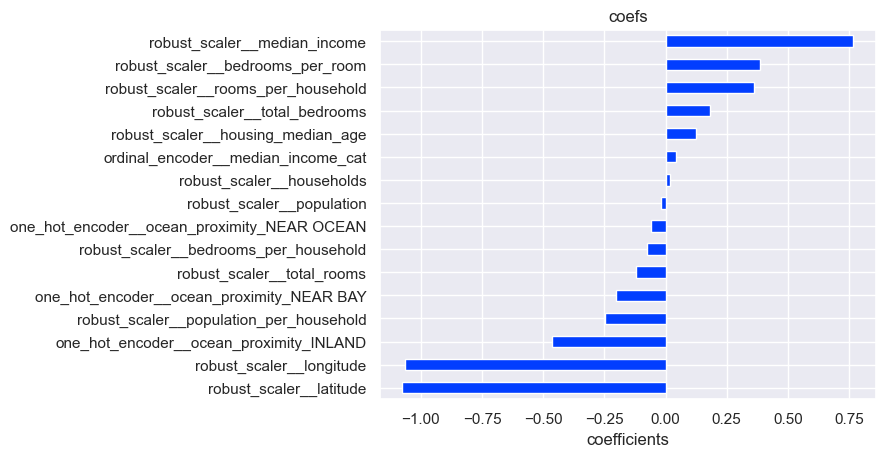

In [13]:
coefs = dataframe_coefs(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

plot_coefs(coefs)

### Testando modelos básicos com Dummy Regressor e Grid Search

In [14]:
regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(),
        'target_transformer': None
    },
    'LinearRegression': {
        'preprocessor': prep_cat,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    'LinearRegression__grid_search': {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_
    },
}

In [15]:
results = {
    name: train_and_validate_regression_model(X, y, **reg)
    for name, reg in regressors.items()
}

df_results = organize_results(results)
df_results

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.001149,0.001069,-0.000023,-75344.044088,-94652.640506,0.002218
1,DummyRegressor,0.00099,0.001068,-0.000097,-77815.127629,-97815.256263,0.002058
2,DummyRegressor,0.000867,0.001394,-0.000306,-76136.496188,-94937.860727,0.002261
3,DummyRegressor,0.0008,0.000925,-0.000177,-77950.972211,-97233.485191,0.001725
4,DummyRegressor,0.000828,0.000921,-0.000351,-76205.284096,-95116.688912,0.001749
5,LinearRegression,0.01012,0.003052,0.675141,-39557.794932,-53948.002512,0.013172
6,LinearRegression,0.009153,0.003115,0.657973,-41974.513341,-57202.610348,0.012268
7,LinearRegression,0.010315,0.002928,0.677336,-40330.00456,-53919.80888,0.013243
8,LinearRegression,0.009746,0.002541,0.668384,-41296.628688,-55988.011878,0.012287
9,LinearRegression,0.00958,0.002503,0.669717,-40331.285341,-54654.198745,0.012083


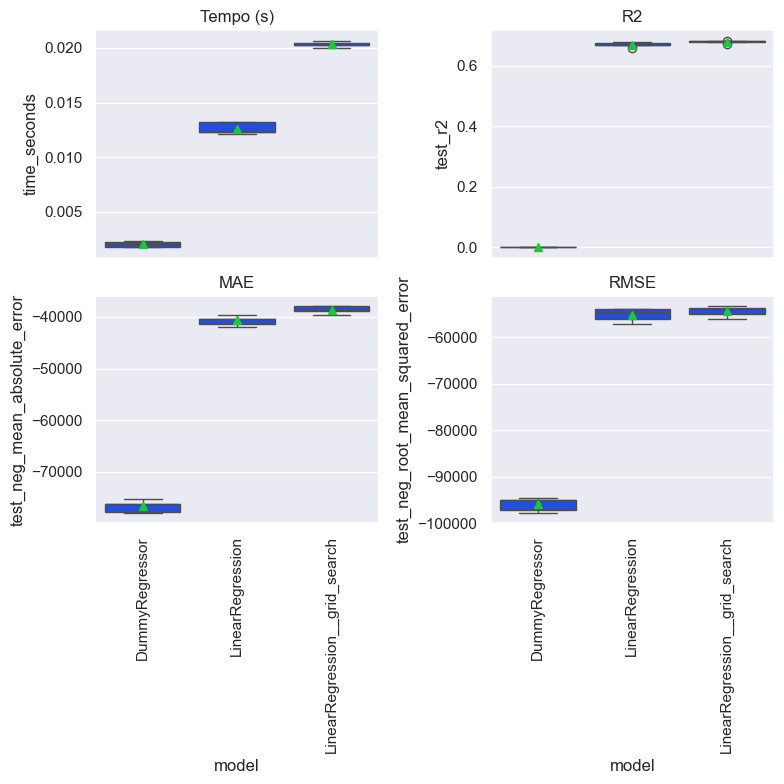

In [16]:
plot_compare_models_metrics(df_results)

### Verificando resíduos do best estimator

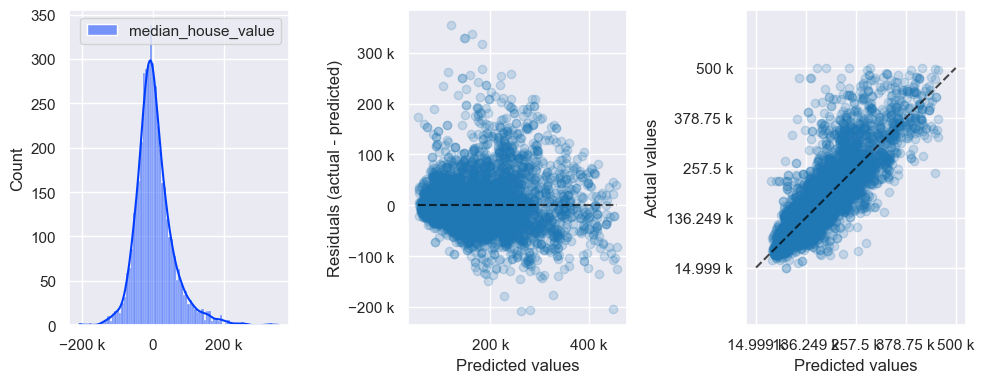

In [17]:
plot_residuals_estimator(grid_search.best_estimator_, X, y)